# A/B Testing: Commitment Check for Online Users in Udacity

In this project, we will implement A/B testing into an education company Udacity. Udacity has diverse collections of courses to help users build their skills, from basics of programming to various expertises. 

For the record, Udacity offers the courses on their website through two buttons:

* **Access Course Materials**, where one views videos, free quizzes, but no premium features such as coachings, verified certificates, and also final project submission for feedbacks.

* **Start Free Trial**, where one could open the premium features by entering their credit card information and then auto-charged after 14 days (unless they cancel beforehand).

Over the course of time, Udacity had frustrated students who left the free trial because they didn't have enough time to finish the course. 

Therefore, Udacity conducts an experiment in the website by changing what happens after we click "Start Free Trial", with a hypothesis to set clearer expectations for the students.

## Experimental Changes

Before the change, users will do the checkout process and get exposed to the features after clicking "Start Free Trial".

To reconsider the users' decision, Udacity conducts an experiment of a pop-up after "Start Free Trial" to ask users how much time they have available for  the course. If they could devote:

* **More than 5 hours per week**: the users will directly proceed into the checkout process
* **Less than 5 hours per week**: there will be notification that Udacity needs commitment for paid users and suggestion to access course for free instead.

This change will be applied to new users. The goals are to make:
* Increasing committed users on the study, 
* Decreasing disappointed users ahead of time, while
* Maintaining the profit from paid users intact.

To assign events into two groups either the control or to the experiment (called unit of diversion), we'll use a cookie. The step starts at clicking "Start Free Trial", which could apply for viewers who have no User ID yet. After enrolling (and by extent making an account), students are tracked by User IDs forward and they cannot enroll in the free trial twice.

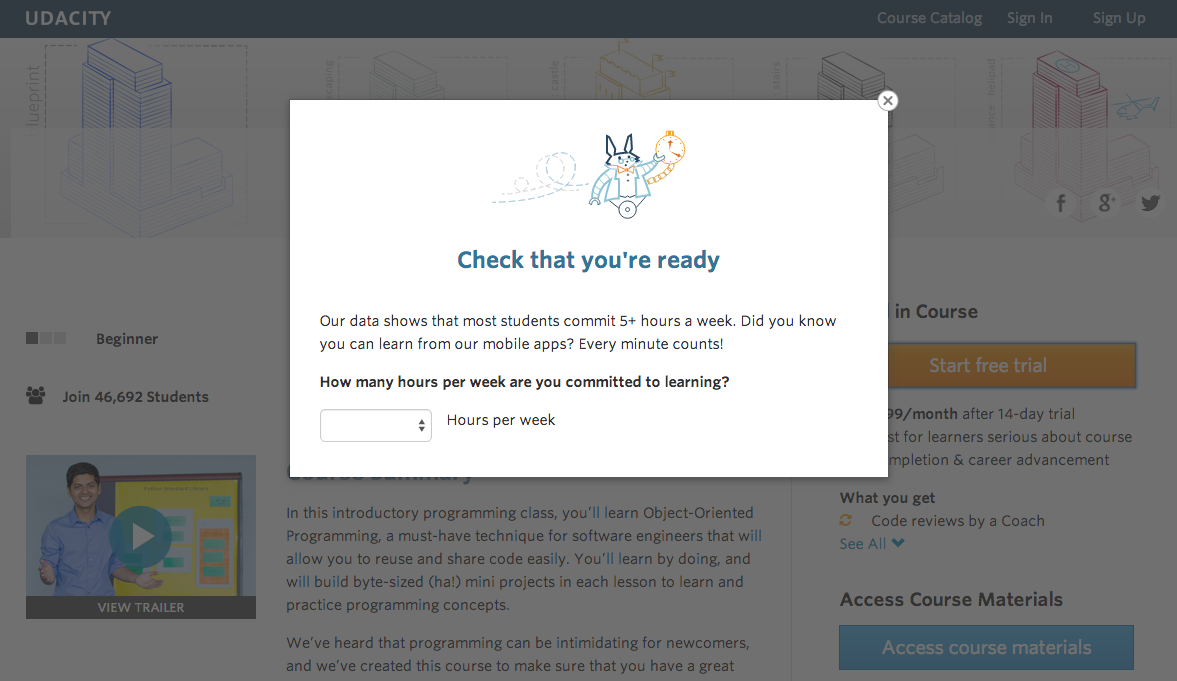

In [1]:
from IPython.display import Image
Image('Final_Project-Experiment_Screenshot.png')

## Experiment Design

In [2]:
import numpy as np
import pandas as pd
import math

### Metric Choice

To reach our goal, we need to define and decide the quantified metrics beforehand, specifically which ones are for evaluation (expected to be different in both groups) and invariant (remained unchanged for both groups). We'll use both:

* Invariant metrics for sanity check (to ensure the experiment doesn't happen by chance), and
* Evaluation matrics for observation to decide launching the experiment.

With their respective estimator of metrics, and also d_min as a threshold to define changes of each metric in the experiment group, we have a handful of options below.

In [3]:
metrics = {'Metric': 
              ['Cookies', 'Clicks', 'User IDs', 'Click through probability', 
               'Gross conversion', 'Retention', 'Net Conversion'],
         'Description': ['Num of unique cookies per day', 
                         'Num of unique clicks per day', 
                         'Num of Enrolled User IDs per day',
                         'Cookies / Clicks',
                         'User IDs / Clicks',
                         'Payments / User IDs',
                         'Payments / Clicks'],
           'Estimator': [40000, 3200, 660, 0.08, 0.20625, 0.53, 0.1093125],
               'd_min': [ 3000,  240,  50, 0.01, 0.01,    0.01, 0.0075]
          }

metrics_data = pd.DataFrame(
                 data=metrics,
                 index=['C', 'CL', 'ID', 'CTP', 'GC', 'R', 'NC']
               )

metrics_data

,Metric,Description,Estimator,d_min
C,Cookies,Num of unique cookies per day,40000.000000,3000.0000
CL,Clicks,Num of unique clicks per day,3200.000000,240.0000
ID,User IDs,Num of Enrolled User IDs per day,660.000000,50.0000
CTP,Click through probability,Cookies / Clicks,0.080000,0.0100
GC,Gross conversion,User IDs / Clicks,0.206250,0.0100
R,Retention,Payments / User IDs,0.530000,0.0100
NC,Net Conversion,Payments / Clicks,0.109313,0.0075


* **Number of Cookies:** Number of unique cookies to view the course overview page
* **Number of User IDs:** Number of users who enroll in the free trial
* **Number of Clicks:** Number of unique cookies to click the "Start Free Trial" button
* **Click-through probability (CTP):** Number of unique cookies to click the "Start Free Trial" button, divided by number of unique cookies to view the course overview page
* **Gross conversion:** Number of User IDs to complete checkout and enroll in the free trial, divided by number of unique cookies to click the "Start Free Trial" button
* **Retention:** Number of User IDs to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by number of User IDs to complete checkout
* **Net conversion:** Number of user IDs to remain enrolled past the 14-day boundary (and thus make at least one payment), divided by the number of unique cookies to click the "Start Free Trial" button

Note: Unique cookies are determined by day; same cookie visiting on different days would be counted twice. Also User IDs are automatically unique since the site doesn't allow the same user ID to enroll twice.

### Invariant and Evaluation Metrics

Amongst the options, we include all into groups of:

* Invariant metrics:
    * **Number of cookies:** Users decide to visit the page before asked
    * **Number of clicks:** Users clicked the button before the pop-up shows up
    * **Click-through probability:** Both metrics above don't change, thus so does this.
* Evaluation metrics:
    * **Gross conversion:** The pop-up filters the committed users
    * **Retention:** After the pop-up filtering we can observe the effect
    * **Net conversion:** Different numbers in both groups marks changes

Remark: Number of User IDs is neither good in both, since it's expected to change in experiment group (not good for invariant) and doesn't show the changes directly (not good for evaluation).

With evaluation metrics in hand and the goals in mind, we can quantify the goal into:

* Increasing committed users on the study >> **Higher retention**
* Reducing disappointed users ahead of time >> **Lower gross conversion**
* Maintaining the profit from paid users intact >> **Same net conversion**

### Measuring Variability

The list above contains rough estimates of the baseline values of these metrics (these numbers have been changed from Udacity's true numbers)

In [4]:
metrics_data['is_eval'] = False

for row in ['GC', 'R', 'NC']:
    metrics_data.loc[row, 'is_eval'] = True

metrics_data.T

,C,CL,ID,CTP,GC,R,NC
Metric,Cookies,Clicks,User IDs,Click through probability,Gross conversion,Retention,Net Conversion
Description,Num of unique cookies per day,Num of unique clicks per day,Num of Enrolled User IDs per day,Cookies / Clicks,User IDs / Clicks,Payments / User IDs,Payments / Clicks
Estimator,40000.0,3200.0,660.0,0.08,0.20625,0.53,0.109313
d_min,3000.0,240.0,50.0,0.01,0.01,0.01,0.0075
is_eval,False,False,False,False,True,True,True


With the values in mind, we can calculate the variability or standard deviation when given a number of sample for A/B testing. Here we're taking 5000 sample out of 40000 unique cookies, so every estimator will be scaled by number of sample taken. 

If the sample is small enough, we'll count the standard deviation of binomial distribution. However, given the large number of sample, the data will shift into a normal distribution. The standard deviation is calculated by:

$$ STD_{metric} = \sqrt{\frac{p(1-p)}{N_{metric}}} $$

with
* p = Probability of metric happening
* N_metric = Unit of diversion (metric's denominator)

In [5]:
import math

metrics_data['STD'] = np.nan

click_through_prob = metrics_data.loc['CTP', 'Estimator']
gross_conversion   = metrics_data.loc[ 'GC', 'Estimator']
retention          = metrics_data.loc[  'R', 'Estimator']
net_conversion     = metrics_data.loc[ 'NC', 'Estimator']

n_pageviews = metrics_data.loc[ 'C', 'Estimator']
n_clicks    = metrics_data.loc['CL', 'Estimator']
n_enroll    = metrics_data.loc['ID', 'Estimator']
n_sample    = 5000

def count_stdev(metrics_value, metric, n_pageviews, n_sample):   
    
    metric_by_sample_to_total_ratio = metric * (n_sample / n_pageviews)
    return math.sqrt(metrics_value * (1-metrics_value) / 
                     metric_by_sample_to_total_ratio)

In [6]:
metrics_data.loc['GC', 'STD'] = (
    count_stdev(gross_conversion, n_clicks, n_pageviews, n_sample))
metrics_data.loc[ 'R', 'STD'] = (
    count_stdev(       retention, n_enroll, n_pageviews, n_sample))
metrics_data.loc['NC', 'STD'] = (
    count_stdev(  net_conversion, n_enroll, n_pageviews, n_sample))

In [7]:
metrics_data.T

,C,CL,ID,CTP,GC,R,NC
Metric,Cookies,Clicks,User IDs,Click through probability,Gross conversion,Retention,Net Conversion
Description,Num of unique cookies per day,Num of unique clicks per day,Num of Enrolled User IDs per day,Cookies / Clicks,User IDs / Clicks,Payments / User IDs,Payments / Clicks
Estimator,40000.0,3200.0,660.0,0.08,0.20625,0.53,0.109313
d_min,3000.0,240.0,50.0,0.01,0.01,0.01,0.0075
is_eval,False,False,False,False,True,True,True
STD,NaN,NaN,NaN,NaN,0.020231,0.054949,0.034353


### Sizing

#### Sample Size

To make sure the experiment is in place, we need to achieve enough statistical significance and power in our analysis. In order to get that, we need minimum sample required for the experiment, calculated as below (assuming common standard deviations):

$$ N_{sample size} = 2 (z_{1-\alpha/2} + z_{1-\beta})^2  * \frac{\sigma^2}{d_{min}^2}$$

where $ \sigma = SE * \sqrt{n} $ and n are number of samples used to count the standard deviation.

Doing A/B testing in both control and experiment groups will result in two (roughly) normal distributions. One distribution (experiment) is shifted from the other, marking a change. But there are overlaps between these two distributions. These are errors in forms of $\alpha$ and $\beta$, ones that we can define for the experiment design.

In short terms, $\alpha$ will act as false positive rate, and $\beta$ will act as false negative rate. Both variables could be defined as: 

* $\alpha$ = Significance level (to determine confidence interval $= 1 - \alpha$ ). The smaller the value, $\alpha$ will widen the margin of data for the control group. Therefore, the average value in experiment group should exceed the margin to reach the confidence interval and confirm the change.

* $\beta$ = Statistical power (to define experiment's sensitivity $= 1 - \beta$ ). The smaller the value, $\beta$ will lengthen the distribution graph, making the corners slimmer and less error. This also means more sample required to confirm the change.

With $\alpha$ and $\beta$ in mind, we can make an experiment design with robust and sensitive metrics.

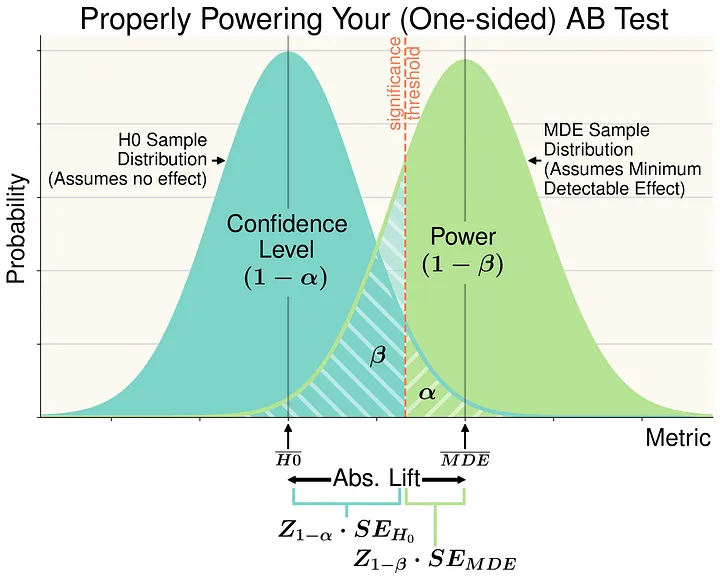

In [8]:
Image('Significance_level-and-Statistical_Power.png')

Another approach to define the sample size is a more precise one (not assuming the standard deviation) through an online calculator, which is what we're using today. We'll be using one from [Evan Miller](https://www.evanmiller.org/ab-testing/sample-size.html).

The terms in the website is defined as follows:
* Baseline conversion rate : Metrics' probability (%)
* Minimum Detectable Effect: d_min (%)
* Absolute / Relative: Absolute
* Statistical power: 1 - $\beta$
* Significance level: 1 - $\alpha$

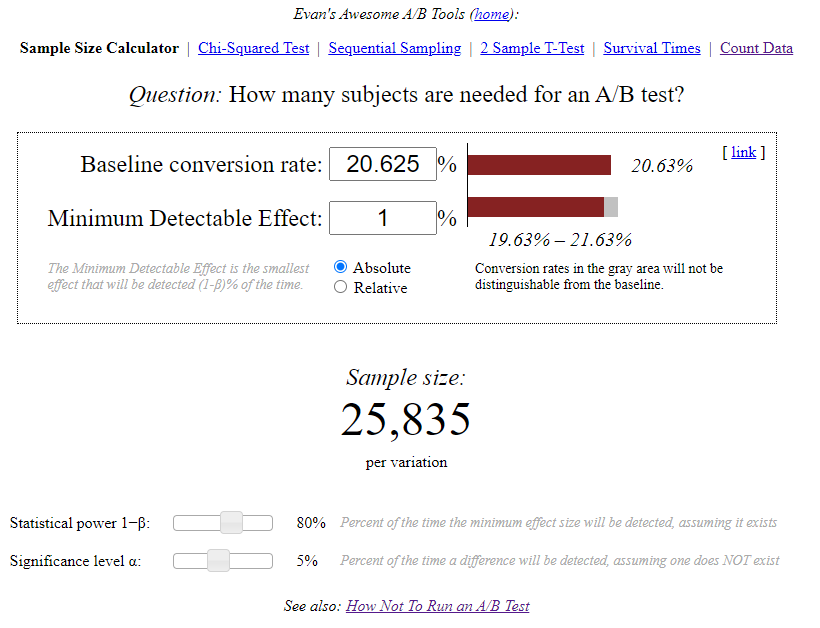

In [9]:
Image('Sample_Size-Gross_Conversion.png')

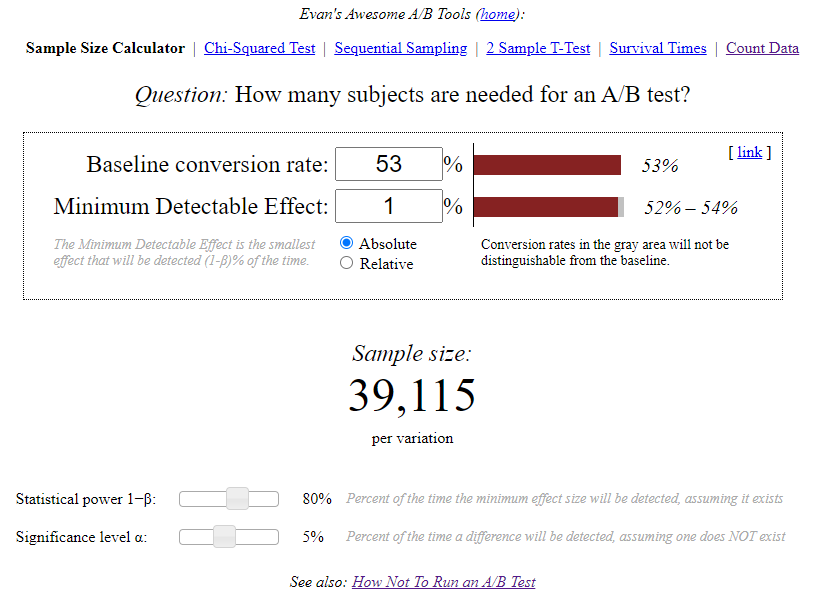

In [10]:
Image('Sample_Size-Retention.png')

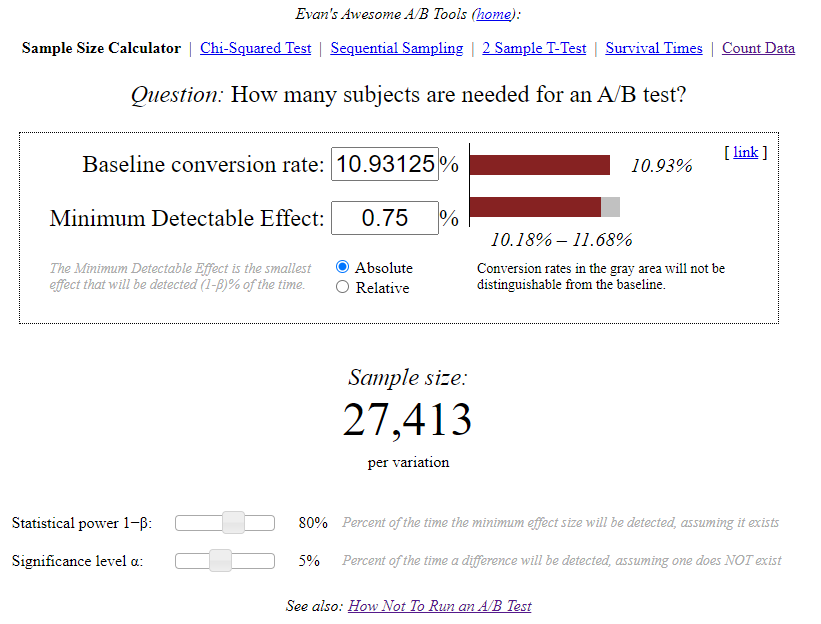

In [11]:
Image('Sample_Size-Net_Conversion.png')

To count the total pageviews needed, we need to compare both the estimators and the sample sizes (double for both control and experiment group)

$$ \frac{2N_{sample size}}{N_{pageviews}} = \frac{N_{real metric}}{N_{real pageviews}} $$

In [12]:
metrics_data.loc['GC', 'sample_size'] = 25835
metrics_data.loc[ 'R', 'sample_size'] = 39115
metrics_data.loc['NC', 'sample_size'] = 27413

metrics_data.loc['GC', 'page_views'] = np.round((2 * 25835) / (3200 / 40000), 2)
metrics_data.loc[ 'R', 'page_views'] = np.round((2 * 39115) / ( 660 / 40000), 2)
metrics_data.loc['NC', 'page_views'] = np.round((2 * 27413) / (3200 / 40000), 2)

In [13]:
metrics_data.T

,C,CL,ID,CTP,GC,R,NC
Metric,Cookies,Clicks,User IDs,Click through probability,Gross conversion,Retention,Net Conversion
Description,Num of unique cookies per day,Num of unique clicks per day,Num of Enrolled User IDs per day,Cookies / Clicks,User IDs / Clicks,Payments / User IDs,Payments / Clicks
Estimator,40000.0,3200.0,660.0,0.08,0.20625,0.53,0.109313
d_min,3000.0,240.0,50.0,0.01,0.01,0.01,0.0075
is_eval,False,False,False,False,True,True,True
STD,NaN,NaN,NaN,NaN,0.020231,0.054949,0.034353
sample_size,NaN,NaN,NaN,NaN,25835.0,39115.0,27413.0
page_views,NaN,NaN,NaN,NaN,645875.0,4741212.12,685325.0


To test all three metrics, we're taking the biggest pageviews needed, which is **4741212 views**, with each metric has $\alpha$ of 0.05. This means 5% could remain

Since we're picking multiple metrics, all metrics sum up to a confidence interval of $(0.95)^3 = 0.857375$ or 85.73% (less than previous one, hence higher rates of false positive/negative). To mitigate this, there's a method called *Bonferroni correction* to ensure the sum of significance level for all metrics don't reach the overall, calculated as 

$$\alpha_{individual} = \frac{\alpha_{overall}}{N_{metric}}$$

However, given that it will increase the number of sample, and we already have 4 million views with regular ${\alpha}$ (more than 100-fold), we'll not use Bonferroni correction and just stick to the current calculation.

Now, with that amount: How long should we do the experiment? Is it sustainable?

#### Duration vs Exposure

Now we have the samples needed, we need to keep in mind about duration. How would be an ideal fit for the company, in terms of 

Assuming there are not other experiments we want to run simultaneously, 

In [14]:
for row in ['GC', 'R', 'NC']:
    metrics_data.loc[row, 'n_days_100%_traffic'] = (
        metrics_data.loc[row, 'page_views'] / 40000)
    metrics_data.loc[row,  'n_days_80%_traffic'] = (
        metrics_data.loc[row, 'n_days_100%_traffic'] / 0.8) 
    metrics_data.loc[row,  'n_days_75%_traffic'] = (
        metrics_data.loc[row, 'n_days_100%_traffic'] / 0.75)     
    metrics_data.loc[row,  'n_days_60%_traffic'] = (
        metrics_data.loc[row, 'n_days_100%_traffic'] / 0.6)
    metrics_data.loc[row,  'n_days_50%_traffic'] = (
        metrics_data.loc[row, 'n_days_100%_traffic'] / 0.5) 
    

In [15]:
metrics_data.T

,C,CL,ID,CTP,GC,R,NC
Metric,Cookies,Clicks,User IDs,Click through probability,Gross conversion,Retention,Net Conversion
Description,Num of unique cookies per day,Num of unique clicks per day,Num of Enrolled User IDs per day,Cookies / Clicks,User IDs / Clicks,Payments / User IDs,Payments / Clicks
Estimator,40000.0,3200.0,660.0,0.08,0.20625,0.53,0.109313
d_min,3000.0,240.0,50.0,0.01,0.01,0.01,0.0075
is_eval,False,False,False,False,True,True,True
STD,NaN,NaN,NaN,NaN,0.020231,0.054949,0.034353
sample_size,NaN,NaN,NaN,NaN,25835.0,39115.0,27413.0
page_views,NaN,NaN,NaN,NaN,645875.0,4741212.12,685325.0
n_days_100%_traffic,NaN,NaN,NaN,NaN,16.146875,118.530303,17.133125
n_days_80%_traffic,NaN,NaN,NaN,NaN,20.183594,148.162879,21.416406


We see that when we're using all 40000 daily users on the website, it will take **at most 118 days** to collect data and calculate the metrics. This is risky since: 

* The experiment takes almost 4 months; too long and not ideal for checking upon the metrics,
* Giving it the 100% traffic also induces risks to decreasing changes to the whole users compared to only a portion of it.

Therefore, we need to find a sweet balance between both number of metrics, duration, and exposure, given all risk considered. Even with all sample, metric of retention seems too risky to play. By that, we can shift our focus to the remaining two metrics instead: gross conversion and net conversion. 

Let's recall on what we've had so far:

* We're experimenting with pop-ups as filter, with an additional information of hours to devote in the course. Risks of change in metrics are relatively harmless compared to severe ones such as commercial or privacy violation. So we can leave the pop-up as is.

* For the result, we will see the effect through the metrics after 14 days. We have calculated several options given a percentage of the whole page views.
    * With 100% traffic, we'll get the result in 17 days, which is relatively quick to look at. We can double the duration for ideal measure (28 days). Throughout the other options, 60% traffic with a duration of **29 days** seem best for conducting the experiment. By that, we're picking **60% traffic** for the exposure.
    
We can also try to apply Bonferroni correction to amp up the ${\alpha}$. However, lower ${\alpha}$ means higher number of samples, and to an extent longer duration. 28 days is already a good duration, so we'll not use the Bonferroni correction.

In [16]:
metrics_data.loc['GC', 'is_metric_used'] = True
metrics_data.loc[ 'R', 'is_metric_used'] = False
metrics_data.loc['NC', 'is_metric_used'] = True

metrics_data.loc[['GC', 'R', 'NC'], :].T

,GC,R,NC
Metric,Gross conversion,Retention,Net Conversion
Description,User IDs / Clicks,Payments / User IDs,Payments / Clicks
Estimator,0.20625,0.53,0.109313
d_min,0.01,0.01,0.0075
is_eval,True,True,True
STD,0.020231,0.054949,0.034353
sample_size,25835.0,39115.0,27413.0
page_views,645875.0,4741212.12,685325.0
n_days_100%_traffic,16.146875,118.530303,17.133125
n_days_80%_traffic,20.183594,148.162879,21.416406


### Experiment Design: Summary

In short, we've made an experiment design with the following specifications:
* We're measuring two metrics for change: **gross conversion** and **net conversion**,
* With ${\alpha}$ of 0.05 on each metric and ${\beta}$ of 80%, we need **685325** pageviews.
* The experiment will be held to **60% traffic** for roughly **29 days**.

## Experiment Analysis

Now we've designed the experiment, we can look at the data collected.

This data contains the raw information needed to compute the above metrics, broken down day by day. Note that there are two sheets within the spreadsheet - one for the experiment group, and one for the control group. The columns are defined as below.

* **Pageviews**: Number of unique cookies to view the course overview page that day.
* **Clicks**: Number of unique cookies to click the course overview page that day.
* **Enrollments**: Number of user-ids to enroll in the free trial that day.
* **Payments**: Number of user-ids who who enrolled on that day to remain enrolled for 14 days and thus make a payment. 
    * **P.S.** Note that the date for this column is the start date, that is, the date of enrollment, rather than the date of the payment. The payment happened 14 days later. Because of this, the enrollments and payments are tracked for 14 fewer days than the other columns, *hence the missing values on the last 14 days*)

We will only count current values available, which is on the first 23 days.

In [17]:
import matplotlib.pyplot as plt

cont = pd.read_csv('Final Project Results - Control.csv')
exp  = pd.read_csv('Final Project Results - Experiment.csv')

In [18]:
cont

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0
5,"Thu, Oct 16",9670,823,138.0,82.0
6,"Fri, Oct 17",9008,748,146.0,76.0
7,"Sat, Oct 18",7434,632,110.0,70.0
8,"Sun, Oct 19",8459,691,131.0,60.0
9,"Mon, Oct 20",10667,861,165.0,97.0


In [19]:
exp

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",9793,832,140.0,94.0
5,"Thu, Oct 16",9500,788,129.0,61.0
6,"Fri, Oct 17",9088,780,127.0,44.0
7,"Sat, Oct 18",7664,652,94.0,62.0
8,"Sun, Oct 19",8434,697,120.0,77.0
9,"Mon, Oct 20",10496,860,153.0,98.0


In [20]:
cont_cut = cont[:23]
exp_cut  = exp[:23]

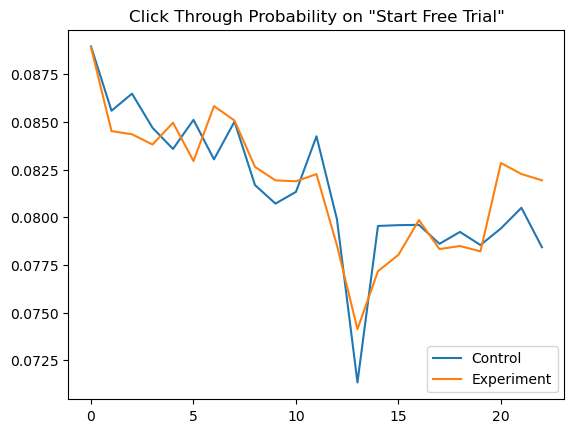

In [21]:
plt.plot(cont_cut['Clicks']/cont_cut['Pageviews'], label='Control')
plt.plot(exp_cut['Clicks']/exp_cut['Pageviews'], label='Experiment')
plt.title('Click Through Probability on "Start Free Trial"')
plt.legend(loc = 'lower right')
plt.show()

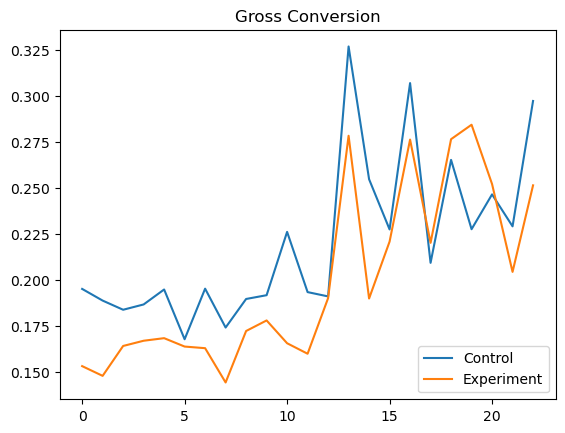

In [22]:
plt.plot(cont_cut['Enrollments']/cont_cut['Clicks'], label='Control')
plt.plot(exp_cut['Enrollments']/exp_cut['Clicks'], label='Experiment')
plt.title('Gross Conversion')
plt.legend(loc = 'lower right')
plt.show()

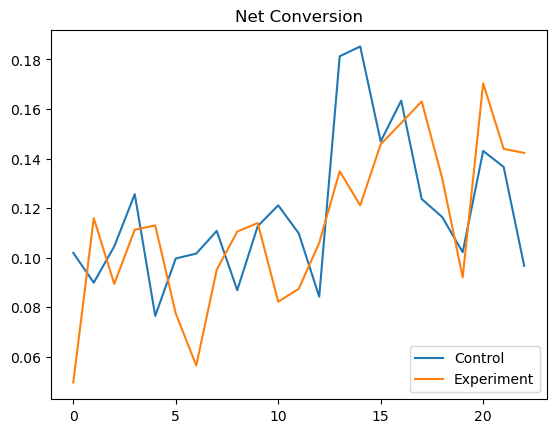

In [23]:
plt.plot(cont_cut['Payments']/cont_cut['Clicks'], label='Control')
plt.plot(exp_cut['Payments']/exp_cut['Clicks'], label='Experiment')
plt.title('Net Conversion')
plt.legend(loc = 'lower right')
plt.show()

### Sanity Checks

Before the count the evaluation metrics, let's check whether our invariant metrics are equivalent between the two groups. 

Based on the experiment design we're dividing it into two groups equally: control and experiment. This means the chance of getting into one of group is the same, here written as p_hat = 0.50. 

In sanity check, we'll confirm if the total amount for our unit of diversion (in this case it's `Clicks`) are in the range of our confidence interval ($\alpha$ = 0.05, $\beta$ = 0.2)

In [24]:
sanity_check = pd.DataFrame(
    index=['Clicks', 'Pageviews', 'CTP'],
    columns=['Control', 'Experiment'])

sanity_check.loc['Clicks', 'Control']    = cont['Clicks'].sum()
sanity_check.loc['Clicks', 'Experiment'] = exp['Clicks'].sum()

sanity_check.loc['Pageviews', 'Control'] = cont['Pageviews'].sum()
sanity_check.loc['Pageviews', 'Experiment'] = exp['Pageviews'].sum()

sanity_check.loc['CTP', 'Control'] = (
    sanity_check.loc['Clicks', 'Control'] / 
    sanity_check.loc['Pageviews', 'Control']
)

sanity_check.loc['CTP', 'Experiment'] = (
    sanity_check.loc['Clicks', 'Experiment'] / 
    sanity_check.loc['Pageviews', 'Experiment']
)

sanity_check['Total'] = (sanity_check['Control'] + sanity_check['Experiment'])

sanity_check['conf_interval'] = 1 - 0.05
sanity_check[  'sensitivity'] = 1 - 0.20

sanity_check

,Control,Experiment,Total,conf_interval,sensitivity
Clicks,28378,28325,56703,0.95,0.8
Pageviews,345543,344660,690203,0.95,0.8
CTP,0.082126,0.082182,0.164308,0.95,0.8


We have seen a data of two groups with a total of 690203 pageviews (a large population), we could do a sanity check via normal distribution. We'll do this through steps:

* We'll compute the Standard Deviation (p_hat = 0.5)
* Find the margin error by multiplying it with z-score from $1 - \alpha$,
* Compute the confidence interval around p_hat,
* Check whether p_sample lies between the range of p_hat.

For a two-tailed $\alpha$ (meaning the significance level ranges between 2.5% and 97.5%), we have a z-score of $\pm$1.96. The list of z-table can be checked [here](https://www.math.upenn.edu/~chhays/zscoretable.pdf).

In [25]:
for row in sanity_check.index:
    sanity_check.loc[row, 'prob_cont'] = (
        sanity_check.loc[row,    'Control'] / sanity_check.loc[row, 'Total'])
    sanity_check.loc[row, 'prob_exp'] = (
        sanity_check.loc[row, 'Experiment'] / sanity_check.loc[row, 'Total'])
    sanity_check.loc[row, 'STD'] = (
        math.sqrt(0.5 * 0.5 / sanity_check.loc[row, 'Total']))

sanity_check['prob_hat'] = 0.5

sanity_check['margin_of_error'] = sanity_check['STD'] * 1.96
sanity_check['lower_bound'] = 0.5 - sanity_check['margin_of_error']
sanity_check['upper_bound'] = 0.5 + sanity_check['margin_of_error']

sanity_check['sanity_check'] = np.where(
    (sanity_check['prob_cont'] > sanity_check['lower_bound']) &
    (sanity_check['prob_cont'] < sanity_check['upper_bound']),
        'Passed', 'Failed')

In [26]:
sanity_check.T

,Clicks,Pageviews,CTP
Control,28378,345543,0.082126
Experiment,28325,344660,0.082182
Total,56703,690203,0.164308
conf_interval,0.95,0.95,0.95
sensitivity,0.8,0.8,0.8
prob_cont,0.500467,0.50064,0.499828
prob_exp,0.499533,0.49936,0.500172
STD,0.0021,0.000602,1.233503
prob_hat,0.5,0.5,0.5
margin_of_error,0.004116,0.00118,2.417666


As we can see, both groups of control and experiment in the data passes the sanity check for all invariant metrics. This means we can assume the data has balanced number of sample in both control and experiment. We can proceed into the next step:

### Practical and Statistical Significance Check

Now we've checked the balanceness of both groups in invariant metrics, we can move on to the evaluation metrics. The steps will be the same, with an addition of practical significance in each metrics by comparing two variables:

* difference of on both groups (marked as **d_pool**), that should be larger than
* minimum detectable effect or a value to mark acceptable change (marked as **d_min**)

The passing checks marks that the change reaches our threshold and we can then launch the experiment. To do calculation, we need to sum the variables on both groups first. 

And to recall: `Enrollments` and `Payments` are collected on 14 fewer days, so we'll be using the for the duration of only 23 days. This will result in lower sample than our initial target sample size (N = 685325 pageviews). However, at this point, there's not much that we can do about it other than taking it into consideration.

We'll use `cont_cut` and `exp_cut` and assign the sums into a DataFrame of `cont_exp_sum`

In [27]:
cont_exp_sum = pd.DataFrame()

for col in ['Clicks', 'Enrollments', 'Payments']:
    cont_exp_sum.loc['Control'   , col] = cont_cut[col].sum()
    cont_exp_sum.loc['Experiment', col] = exp_cut[col].sum()
    
cont_exp_sum

,Clicks,Enrollments,Payments
Control,17293.0,3785.0,2033.0
Experiment,17260.0,3423.0,1945.0


For the standard deviation of both group, we'll calculate it with

$$ STD_{metric} = \sqrt{ p(1-p)( \frac{1}{N_{cont}} + \frac{1}{N_{exp}}) } $$

In [30]:
## GC: Gross Conversion
## NC: Net Conversion

launch_check = pd.DataFrame(index=['GC', 'NC'],
                  columns=['alpha', 'beta'])

launch_check['alpha'] = 0.05
launch_check['beta']  = 0.20

## Target: GC down (less frustrated students),
##         NC up (profit is same or even going up)
launch_check.loc['GC', 'd_min'] = -0.0100
launch_check.loc['NC', 'd_min'] =  0.0075

## Calculate d_pool:
launch_check.loc['GC', 'p_cont'] = (
    cont_exp_sum.loc['Control', 'Enrollments'] / 
    cont_exp_sum.loc['Control', 'Clicks']) 
launch_check.loc['NC', 'p_cont'] = (
    cont_exp_sum.loc['Control', 'Payments'] / 
    cont_exp_sum.loc['Control', 'Clicks']) 

launch_check.loc['GC', 'p_exp'] = (
    cont_exp_sum.loc['Experiment', 'Enrollments'] / 
    cont_exp_sum.loc['Experiment', 'Clicks']) 
launch_check.loc['NC', 'p_exp'] = (
    cont_exp_sum.loc['Experiment', 'Payments'] / 
    cont_exp_sum.loc['Experiment', 'Clicks']) 

# Find the range of d_pool
launch_check['d_pool'] = launch_check['p_exp'] - launch_check['p_cont']

launch_check

,alpha,beta,d_min,p_cont,p_exp,d_pool
GC,0.05,0.2,-0.0100,0.218875,0.198320,-0.020555
NC,0.05,0.2,0.0075,0.117562,0.112688,-0.004874


In [32]:
# Find margin error for our d_pool
launch_check.loc['GC', 'p_pool'] = (
    cont_exp_sum['Enrollments'].sum() / cont_exp_sum['Clicks'].sum()) 
launch_check.loc['NC', 'p_pool'] = (
    cont_exp_sum['Payments'].sum() / cont_exp_sum['Clicks'].sum())

N_pool = (1 / cont_exp_sum.loc['Control', 'Clicks'] +
          1 / cont_exp_sum.loc['Experiment', 'Clicks'])

for row in ['GC', 'NC']:
    launch_check.loc[row, 'STD_pool'] = math.sqrt(
        N_pool * launch_check.loc[row, 'p_pool'] * 
        (1 - launch_check.loc[row, 'p_pool'])) 

launch_check['margin_of_error'] = launch_check['STD_pool'] * 1.96

# Define range interval for d_pool
launch_check['lower_bound']     = (
    launch_check['d_pool'] - launch_check['margin_of_error'])
launch_check['upper_bound']     = (
    launch_check['d_pool'] + launch_check['margin_of_error'])

launch_check['stat_sign_check'] = np.where(
    (launch_check['lower_bound'] <= 0) & (0 >= launch_check['upper_bound']),
    'Passed', 'Failed')

# Practical Significance:
# Making sure d_min is smaller than the entire confidence interval,
# confirming acceptable threshold for the experiment:
## d_min > 0: `lower_bound` and `d_pool` are more than d_min
## d_min < 0: `d_pool` and `upper bound` are less than d_min

for m in ['GC', 'NC']:
    if (launch_check.loc[m, 'd_min'] >= 0):
        launch_check.loc[m, 'prac_sign_check'] = np.where(
            (launch_check.loc[m, 'd_pool']      > launch_check.loc[m, 'd_min']) &
            (launch_check.loc[m, 'lower_bound'] > launch_check.loc[m, 'd_min']),
        'Passed', 'Failed')
    else:
        launch_check.loc[m, 'prac_sign_check'] = np.where(
            (launch_check.loc[m, 'd_pool']      < launch_check.loc[m, 'd_min']) &
            (launch_check.loc[m, 'upper_bound'] < launch_check.loc[m, 'd_min']),
        'Passed', 'Failed')

launch_check.T

,GC,NC
alpha,0.05,0.05
beta,0.2,0.2
d_min,-0.01,0.0075
p_cont,0.218875,0.117562
p_exp,0.19832,0.112688
d_pool,-0.020555,-0.004874
p_pool,0.208607,0.115127
STD_pool,0.004372,0.003434
margin_of_error,0.008568,0.006731
lower_bound,-0.029123,-0.011605


We can see from the value of `d_pool` that both check passes for `Gross Conversion` but not for `Net Conversion`. This means that:

* The experiment will decrease the number of students who enroll beyond the threshold, with 
    * **`d_min` = -0.010, `d_pool` = -0.020555, `upper_bound` = -0.011986**
* However, it would most likely decrease number of users who checkouts after 14-day boundary, making risk financially, with
    * **`d_min` =  0.0075, `d_pool` = -0.004874, `lower_bound` = -0.011605**

### Double-Check: Sign Tests

To double check the significance levels, we can look up data per day and count the success observed amongst the whole duration. 23 days are a small sample, therefore we will assume a Poisson Distribution and count the through an online calculator [here](https://www.graphpad.com/quickcalcs/binomial1.cfm).

We will count two-tailed p-value through number of successes, number of trials, and a probability of 0.5. Afterwards we'll compare it with $\alpha$ = 0.05 as our  confidence interval to check for sign tests. 

In [33]:
cont_cut.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


In [34]:
exp_cut.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",9793,832,140.0,94.0


In [37]:
cont_cut['Date'].count()

23

In [57]:
launch_check.loc['GC', 'num_of_success'] = (
    ( exp_cut['Enrollments'] /  exp_cut['Clicks']) >
    (cont_cut['Enrollments'] / cont_cut['Clicks'])
).sum()
launch_check.loc['GC', 'num_of_trials'] = cont_cut['Date'].count()

launch_check.loc['NC', 'num_of_success'] = (
    ( exp_cut['Payments'] /  exp_cut['Clicks']) >
    (cont_cut['Payments'] / cont_cut['Clicks'])
).sum()
launch_check.loc['NC', 'num_of_trials'] = exp_cut['Date'].count()

launch_check.T

,GC,NC
alpha,0.05,0.05
beta,0.2,0.2
d_min,-0.01,0.0075
p_cont,0.218875,0.117562
p_exp,0.19832,0.112688
d_pool,-0.020555,-0.004874
p_pool,0.208607,0.115127
STD_pool,0.004372,0.003434
margin_of_error,0.008568,0.006731
lower_bound,-0.029123,-0.011605


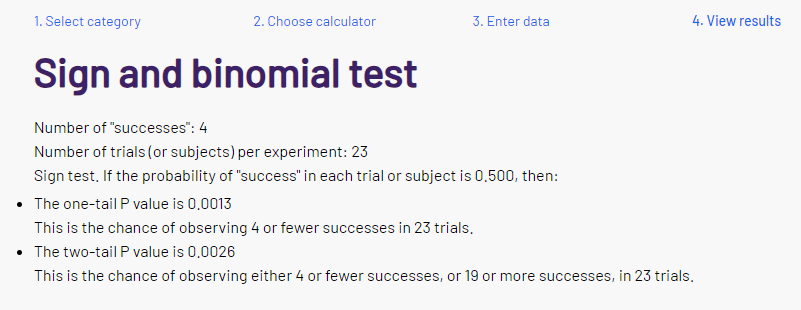

In [44]:
Image('Sign_Test-Gross_Conversion.png')

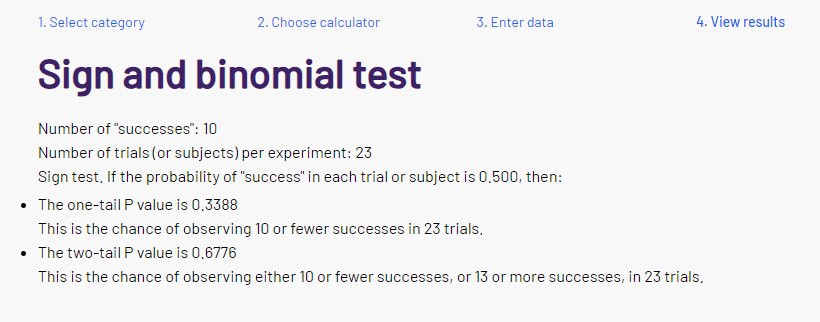

In [45]:
Image('Sign_Test-Net_Conversion.png')

In [48]:
launch_check.loc['GC', 'sign_test_p_value'] = 0.0028
launch_check.loc['NC', 'sign_test_p_value'] = 0.6776

for m in ['GC', 'NC']:
    launch_check.loc[m, 'sign_test_check'] = np.where(
        launch_check.loc[m, 'sign_test_p_value'] < 
        launch_check.loc[m, 'alpha'], 'Passed', 'Failed')
    
launch_check.T

,GC,NC
alpha,0.05,0.05
beta,0.2,0.2
d_min,-0.01,0.0075
p_cont,0.218875,0.117562
p_exp,0.19832,0.112688
d_pool,-0.020555,-0.004874
p_pool,0.208607,0.115127
STD_pool,0.004372,0.003434
margin_of_error,0.008568,0.006731
lower_bound,-0.029123,-0.011605


## Recommendations

We had several findings on the two metrics we've measured:

* The difference of Gross Conversion or `GC` (Enrollments / Clicks) is **practically significant and negative**. This could reach one of Udacity's goals, which is to **decrease** the number of frustrated students who can't make it due to time.

* Net Conversion or `NC` (Payments / Clicks) is **not practically significant and mostly in negative distribution**. Even though the experiment is out of our confidence interval, it will most likely **risk to decreasing profits** compared to the status quo.

The author recommends **not to launch the experiment** due to higher risk of lower profit compared to the impact of filtering frustrated students.

We can gain more insights for the experiment by:
* More data capture to reach the minimal number of sample size. We can amp up the duration from 37 days (23+14) to 43 days (29+14) to fulfill the required durations.
* Including retention rate at the table. Even though it takes higher amount of sample, the metric of (Enrollments / Payments) could measure both frustrated students and the profit simultaneously,